# Take home 1


### 1. Integrate url data

In [18]:
# import packages
import os
import pandas as pd
import geopandas as gpd
import folium
import json
import re
from datetime import datetime

import folder

In [19]:
# set folder
os.chdir(folder.j_url)
# print(os.listdir())

# create dictionary of all 16 files and dictionary of file > date
# regex used to return the dates from file names
url_dfs = {}
url_time_dict = {}

for file in os.listdir():
    if file.endswith("csv"):
        match_date = re.search(r'\d{7}', file).group()
        date = datetime.strptime(match_date, "%m%d%Y").date()
        df = pd.read_csv(file, low_memory=False)
        df["date"] = date
        url_dfs[file] = df
        print(f"add {file} to url_dfs (dict),\ncolumns: {df.columns},\ndimension: {df.shape} \n")
        url_time_dict[file] = str(date)
        print(f"add {file} to url_time_dict as key with time as value\n")

print(url_time_dict)

# save file > date dictionary as json
with open("url_scrape_time.json", "w") as outfile:
    json.dump(url_time_dict, outfile, indent=4)

# combine file, drop duplicates for job_url
jurl_df = pd.concat(url_dfs, ignore_index=True).drop_duplicates(subset=["job_url"])
print(f"{len(url_dfs)} url files combined,\nnumber of unique url: {len(jurl_df)}\n\n")

add job_urls_for_parsehub_5172022_v1.csv to url_dfs (dict),
columns: Index(['job_url', 'date'], dtype='object'),
dimension: (4093, 2) 

add job_urls_for_parsehub_5172022_v1.csv to url_time_dict as key with time as value

add job_urls_for_parsehub_5172022_v2.csv to url_dfs (dict),
columns: Index(['job_url', 'date'], dtype='object'),
dimension: (2271, 2) 

add job_urls_for_parsehub_5172022_v2.csv to url_time_dict as key with time as value

add job_urls_for_parsehub_5172022_v3.csv to url_dfs (dict),
columns: Index(['job_url', 'date'], dtype='object'),
dimension: (2271, 2) 

add job_urls_for_parsehub_5172022_v3.csv to url_time_dict as key with time as value

add job_urls_for_parsehub_5172022_v4.csv to url_dfs (dict),
columns: Index(['job_url', 'date'], dtype='object'),
dimension: (2271, 2) 

add job_urls_for_parsehub_5172022_v4.csv to url_time_dict as key with time as value

add job_urls_for_parsehub_5172022_v5.csv to url_dfs (dict),
columns: Index(['job_url', 'date'], dtype='object'),
dim

### 2. Integrate jon information data

In [20]:
# set folder
os.chdir(folder.j_info)
print(f"files in the folder: {os.listdir()}\n")

# read files into a dictionary
info_dfs = {}
for file in os.listdir():
    if file.endswith("csv") or file.endswith("json"):
        match_date = re.search(r'\d{7}', file)
        if match_date:
            date = datetime.strptime(match_date.group(), "%m%d%Y").date()
        if file.endswith("json"):
            with open(file, "r", encoding="utf8") as f:
                data = json.load(f)
                df = pd.json_normalize(data, record_path=["lnks"])
                df["date"] = date
                info_dfs[file] = df
                print(f"add {file} to info_dfs (dict),\ncolumns: {df.columns},\ndimension: {df.shape}\n")
        elif file.endswith("csv"):
            df = pd.read_csv(file, low_memory=False)
            df.columns = df.columns.str.removeprefix("lnks_")
            info_dfs[file] = df
            df["date"] = date
            print(f"add {file} to info_dfs (dict),\ncolumns: {df.columns},\ndimension: {df.shape} \n")
# print(list(info_dfs.keys()))

# concat and clean
jinfo_df = pd.concat(info_dfs, ignore_index=True).drop_duplicates(subset=["link"])
jinfo_df = jinfo_df.dropna(subset=["job_title", "job_description"], how="any").reset_index(drop=True)
print(f"{len(info_dfs)} files combined,\nduplicates dropped,\nna from job_title and job_description dropped,\n"
      f"total entries: {len(jinfo_df)}\n\n")

files in the folder: ['parsehub_5172022_v1.csv', 'parsehub_5172022_v2.csv', 'parsehub_5182022_v1.csv', 'parsehub_5182022_v2.json', 'parsehub_5192022_v1.csv', 'parsehub_5192022_v2.csv', 'parsehub_5202022_v1.csv', 'parsehub_5202022_v2.json', 'parsehub_5212022_v1.csv', 'parsehub_5212022_v2.csv', 'parsehub_5222022_v1.csv', 'parsehub_5222022_v2.csv', 'parsehub_5222022_v3.csv', 'parsehub_5222022_v4.csv', 'parsehub_5222022_v5.csv', 'parsehub_5222022_v6.csv', 'parsehub_5232022_v1.csv', 'parsehub_5232022_v2.csv']

add parsehub_5172022_v1.csv to info_dfs (dict),
columns: Index(['link', 'job_title', 'company', 'company_url', 'company_location',
       'job_description', 'date'],
      dtype='object'),
dimension: (3140, 7) 

add parsehub_5172022_v2.csv to info_dfs (dict),
columns: Index(['link', 'job_title', 'company', 'company_url', 'company_location',
       'job_description', 'date'],
      dtype='object'),
dimension: (3525, 7) 

add parsehub_5182022_v1.csv to info_dfs (dict),
columns: Index(['

### 3. Merge job info data and url data

In [21]:
# take files from other py
job_df = jinfo_df
print(job_df.columns, job_df.shape, sep=os.linesep)
search_df = jurl_df.rename(columns={"job_url": "link"})
print(search_df.columns, search_df.shape, sep=os.linesep)

# merge job info data into search links
matched = pd.merge(search_df, job_df,
                   how="left",
                   on="link",
                   suffixes=("_search", "_return"),
                   validate="1:1"
                   ).reset_index(drop=True)

# create a column to check completeness status of data
matched.loc[matched.notna().all(axis=1), "status"] = "complete"
matched.loc[matched["job_title"].isna(), "status"] = "missing"
matched["status"] = matched["status"].fillna(value="partial")

# create a columns to check time discrepancies
matched.loc[matched["date_search"] != matched["date_return"], "time_diff"] = "discrepancy"
print(matched.columns, matched, sep=os.linesep)

Index(['link', 'job_title', 'company', 'company_url', 'company_location',
       'job_description', 'date'],
      dtype='object')
(9227, 7)
Index(['link', 'date'], dtype='object')
(21260, 2)
Index(['link', 'date_search', 'job_title', 'company', 'company_url',
       'company_location', 'job_description', 'date_return', 'status',
       'time_diff'],
      dtype='object')
                                                    link date_search  \
0      https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...  2022-05-17   
1      https://www.indeed.com/rc/clk?jk=bf3aa4d4d8608...  2022-05-17   
2      https://www.indeed.com/rc/clk?jk=ceee36181304b...  2022-05-17   
3      https://www.indeed.com/rc/clk?jk=e9735aea38be9...  2022-05-17   
4      https://www.indeed.com/company/Swiss-American-...  2022-05-17   
...                                                  ...         ...   
21255  https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...  2022-05-23   
21256  https://www.indeed.com/rc/clk?jk=4c78c7807

#### 3.1. Tabulate

In [22]:

tabl_search = pd.crosstab(matched.date_search, matched.status, margins=True)
tabl_return = pd.crosstab(matched.date_return, matched.status, margins=True)
print(f"\nTabulation table for missing, partial, and complete entries by date of search:\n{tabl_search}\n")
print(f"\nTabulation table for partial and complete entries by date of information returned:\n{tabl_return}\n")


Tabulation table for missing, partial, and complete entries by date of search:
status       complete  missing  partial    All
date_search                                   
2022-05-17        722     4442       93   5257
2022-05-18        356      954       15   1325
2022-05-19       1328     2323      147   3798
2022-05-20       3972      263      288   4523
2022-05-21       1455      516      183   2154
2022-05-22        519      112      149    780
2022-05-23          0     3423        0   3423
All              8352    12033      875  21260


Tabulation table for partial and complete entries by date of information returned:
status       complete  partial   All
date_return                         
2022-05-17        722       93   815
2022-05-18        356       15   371
2022-05-19       1163      129  1292
2022-05-20        165       18   183
2022-05-21       2750      219  2969
2022-05-22       2677      252  2929
2022-05-23        519      149   668
All              8352      875  

#### 3.2. Discussion
- Valid job data totalled 9,227 entries, which is 43% of total unique urls scraped from May 17 to May 23, which totalled 21,260.
- Most missing data is concentrated at the two end of the scraping window. Most notably there was no matching on the last day. However, this is deceptive, since there seems to be some descrepancies between tallying using the search date and the result date. One possible scenario is that the results for scraping is registered latter, hence leading to the lag, which is supported by data pattern across the two tabulation tables. The scraping yield improved substantially towards the end of scraping period as well.
- In my opinion, data yield seems reasonable and where data is complete (90%), random item check shows information provided to have been substantial and can be used to further categorize data using key words. It is hard to tell what is behind the missing data patterns without understanding how the scraping algorithm works (and also how search algorithm from indeed.com work as well). Perhaps some keywords pertaining to different industries led to different yields, or compliance is over-represented in some industries, or geographical areas. Other technical reasons can be how job descriptions are worded that makes it harder to scrape for some than other. I would go back to check the algorith to minimize the change of non-random sampling bias.

### 4. Job geographical distribution

In [23]:
# data setup
os.chdir(folder.geo_dir)
state_gdf = gpd.read_file("states.geojson")
print(state_gdf.columns, "\n", state_gdf.STUSPS, "\n")

state_gdf = state_gdf.rename(columns={"STUSPS": "state_code", "NAME": "state_name"})
state_list = state_gdf.state_code.tolist()

job_info = jinfo_df
print(job_info.company_location, "\n")

job_location = job_info.company_location.tolist()

# isolate state_code from company location
# more stringent regex r" [A-Z]{2} |[A-Z]{2}\Z" will return jobs in Puerto Rico (PR) which is not in geojson
# str.strip() is then required to create matches
for i in range(len(job_location)):
    match = re.search(r"[A-Z]{2}", job_location[i])
    if match:
        match_state = str.strip(match.group())
        if match_state in state_list:
            job_info.loc[i, "state_code"] = match_state
        else:
            job_info.loc[i, "state_code"] = "no state info"
    else:
        job_info.loc[i, "state_code"] = "no state info"

print(job_info, "\n")

# tally jobs by state
job_by_state = job_info.groupby("state_code").agg({"job_title": "count"}).reset_index()
job_by_state = job_by_state.drop(index=51)
print(job_by_state)

# merge with geometry data and set data as geodata
job_map = state_gdf[["state_code", "geometry"]].merge(job_by_state, how="left", on="state_code").reset_index(drop=True)
job_map = gpd.GeoDataFrame(job_map, geometry="geometry").reset_index(drop=True)
print(job_map.crs)
print(job_map.columns, "\n", job_map, "\n")

Index(['STATEFP', 'STUSPS', 'NAME', 'geometry'], dtype='object') 
 0     NE
1     WA
2     NM
3     SD
4     KY
5     GA
6     AR
7     PA
8     MS
9     CO
10    UT
11    TN
12    WY
13    IN
14    AK
15    NV
16    IL
17    VT
18    MT
19    IA
20    SC
21    AZ
22    OH
23    AL
24    WI
25    OR
26    MO
27    NC
28    OK
29    VA
30    WV
31    LA
32    MI
33    MA
34    ID
35    FL
36    KS
37    NH
38    DE
39    TX
40    MN
41    CT
42    NJ
43    ND
44    MD
45    ME
46    HI
47    RI
48    CA
49    NY
50    DC
Name: STUSPS, dtype: object 

0           Happy Valley Ranch, AZ
1       Colorado Springs, CO 80906
2                  Craig, CO 81625
3           Wethersfield, CT 06109
4             Carrollton, TX 75006
                   ...            
9222             Augusta, GA 30904
9223        Indianapolis, IN 46201
9224          Saint Petersburg, FL
9225                Mesa, AZ 85204
9226             Saginaw, MI 48638
Name: company_location, Length: 9227, dtype: object 

     

#### 4.1. Create map
Based on the map, scraped compliance job from May 17-23 concentrated in California and Texas

<AxesSubplot:>

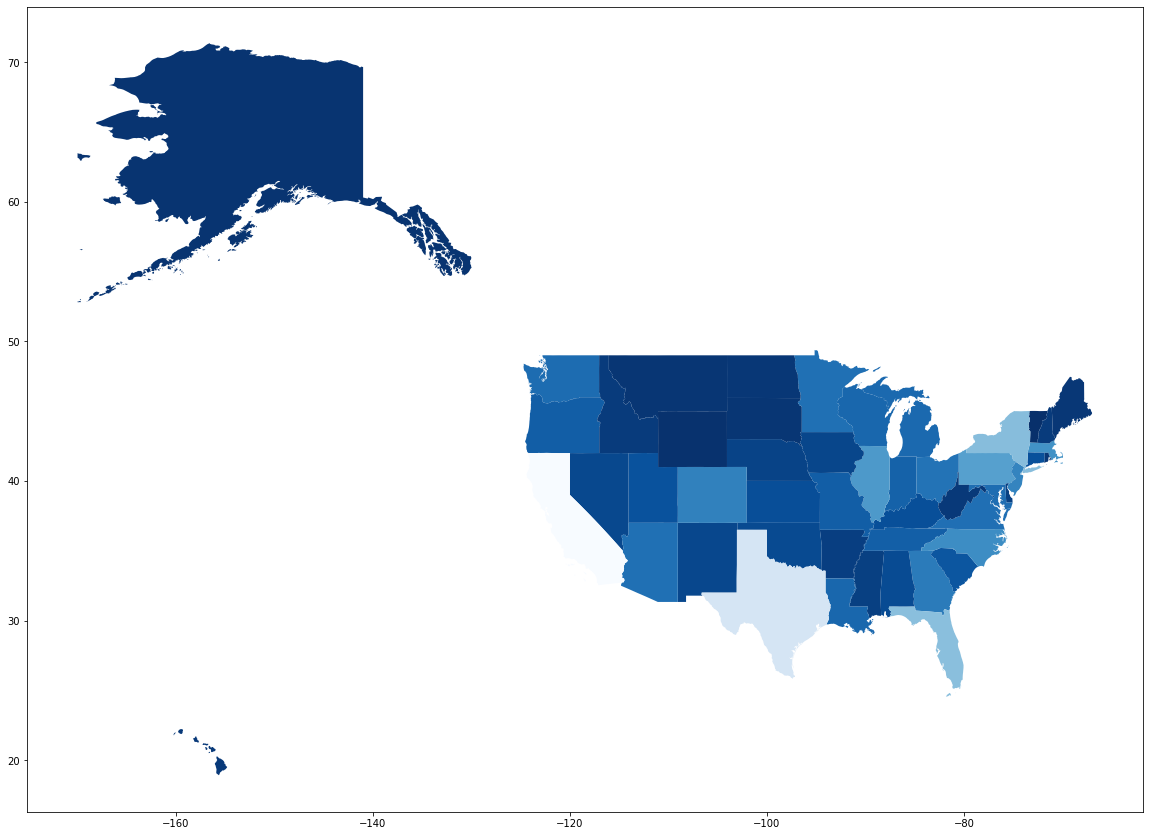

In [24]:
# map
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=20,20

m = job_map.plot(column="job_title", cmap="Blues_r")
display(m)

# # folium map below, but for some reason doesn't process properly...
# m = folium.Map(location=[40, -95], zoom_start=4)
# folium.Choropleth(
#     geo_data=job_map,
#     name="choropleth",
#     data=job_map,
#     columns=["state_code", "job_title"],
#     key_on="feature.properties.state_code",
#     fill_color="YlGn",
#     fill_opacity=0.7,
#     line_opacity=0.4,
#     legend_name="Scraped compliance jobs (May 17-23) by state in the US,\n"
#                 "765 jobs with no location data,\n"
#                 "Jobs in Puerto Rico not shown"
# ).add_to(m)